# Final Project | Katie Hahm | 12/08/20

Github link: 

## Problem set-up

In [120]:
# imports... nothing to see here
import numpy as np  
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import Image
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold
from sklearn import datasets, svm, metrics, preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingClassifier
from scipy import stats 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from numpy import loadtxt
from numpy import sort
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel


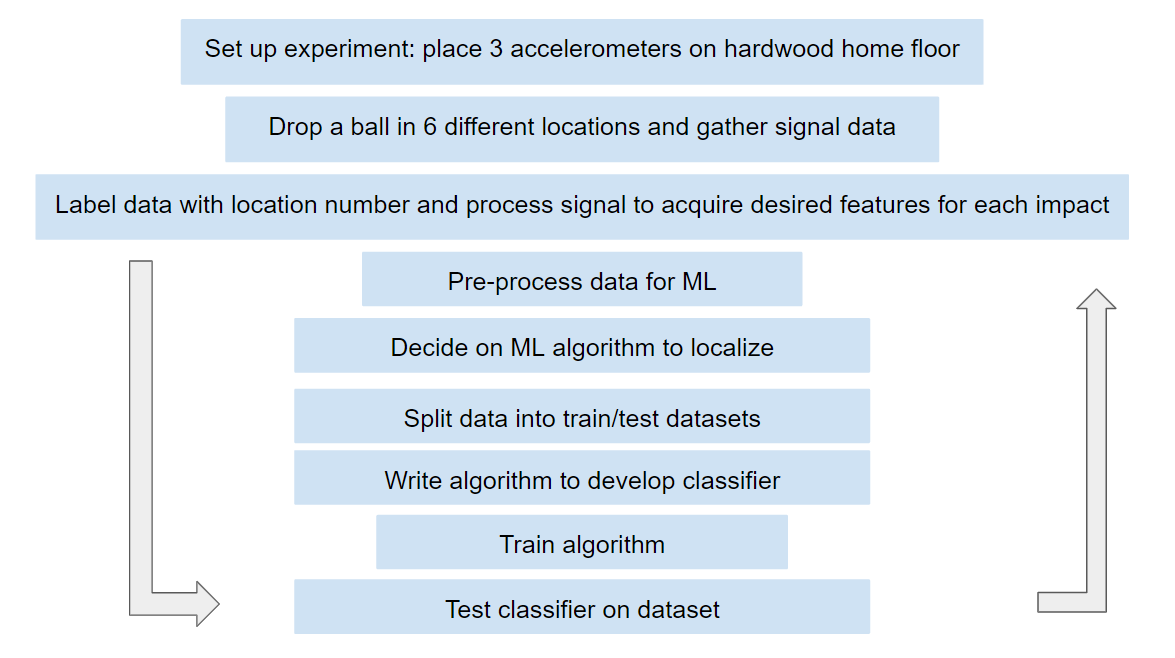

In [121]:
Image("workflow2ball.png")

In [261]:
# read csv file
data = pd.read_csv('walkingData10202020.csv',header=None)
data2 = pd.read_csv('walkingDataChangeLbl.csv',header=None)
# data
data_labels = data.iloc[0]
# take out the first row
data = data.drop(data.index[0])
data = data.apply(pd.to_numeric, errors='coerce')
# convert from pandas dataframe to numpy array
dataM = pd.DataFrame(data).to_numpy()
sh = dataM.shape
nrows = sh[0]
ncols = sh[1]

data2 = data2.drop(data2.index[0])
data2 = data2.apply(pd.to_numeric, errors='coerce')
# convert from pandas dataframe to numpy array
dataM2 = pd.DataFrame(data2).to_numpy()
outputs_unorder = dataM[:,ncols-1]

We want to use L1 normalization to be more robust against outliers in the data. The steps are highly variable, and there are outliers where I may have stepped harder than a natural footfall.

In [230]:

# define inputs/outputs
outputs = dataM[:,ncols-1]
inputs = dataM[:,0:ncols-1]
inputsNorm = preprocessing.normalize(inputs, norm='l1')

# one hot encoder to change labels 
enc = OneHotEncoder(sparse=False)
y_onehot = enc.fit_transform(outputs.reshape(-1,1))

# cross validation to increase amount of data
n_fold = 10
k_fold = KFold(n_splits=n_fold, shuffle=True,random_state=30)
sk_fold = StratifiedKFold(n_splits=n_fold,shuffle=True)

# from XGBoost remove features 2,3,6,7
reducedInputsNorm = np.delete(inputsNorm,2,1)
reducedInputsNorm = np.delete(reducedInputsNorm,2,1)
reducedInputsNorm = np.delete(reducedInputsNorm,4,1)
reducedInputsNorm = np.delete(reducedInputsNorm,4,1)

# coordinate outputs for regression
coord_outputs = np.zeros((nrows,2)) # initialize a 2D coordinate
for i,output in enumerate(outputs):
    if output == 1:
        coord_outputs[i,0] = 1
        coord_outputs[i,1] = 1
    elif output == 2:
        coord_outputs[i,0] = 1
        coord_outputs[i,1] = 2
    elif output == 3:
        coord_outputs[i,0] = 1
        coord_outputs[i,1] = 3
    elif output == 4:
        coord_outputs[i,0] = 1
        coord_outputs[i,1] = 4
    elif output == 5:
        coord_outputs[i,0] = 2
        coord_outputs[i,1] = 4
    elif output == 6:
        coord_outputs[i,0] = 3
        coord_outputs[i,1] = 4

In [227]:
# pass in output array y coord_outputs (2D)
# output labels array (1D)
def uncoordinate(y):
    n = y.shape[0]
    uncoord_outputs = np.zeros((n,))
    for i,outval in enumerate(y):
        if outval[0] == 1:
            uncoord_outputs[i] = outval[1]
        elif outval[0] == 2:
            uncoord_outputs[i] = 5
        elif outval[0] == 3:
            uncoord_outputs[i] = 6
    return uncoord_outputs

## Normalized input data distribution

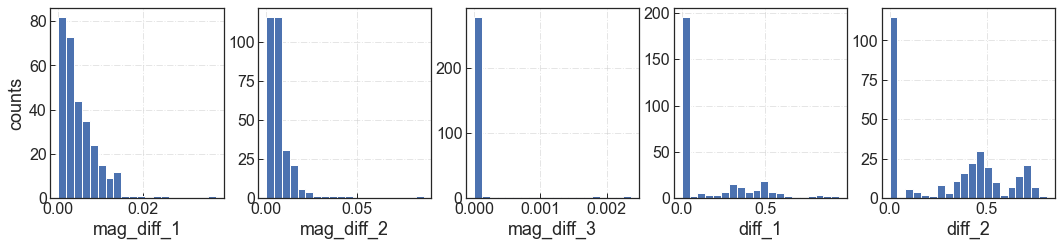

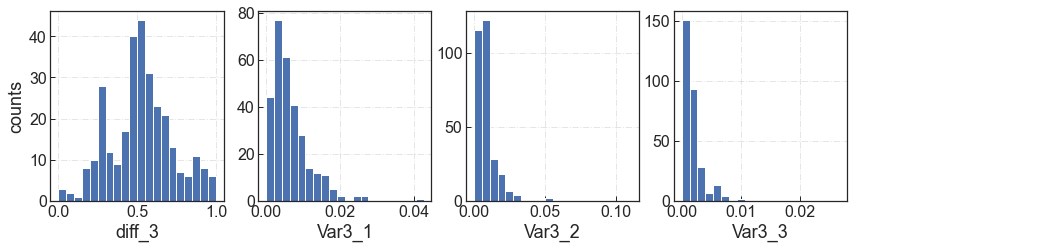

In [202]:
# adapted from week 3 data_visual_cement_dataset
n_col = ncols//2
for n in np.arange(0, 6, n_col):
    fig,axes = plt.subplots(1, n_col, figsize=(18, 3.5), sharey = False)
    fs = 20
    for i in np.arange(n_col):
        if n < len(data_labels)-1:
            axes[i].hist(inputsNorm[:,n], bins = 20)
            axes[i].set_xlabel(data_labels[n], fontsize = 18)
        else:
            axes[i].axis("off")
        n = n+1      
    axes[0].set_ylabel('counts', fontsize = 18)
    for i in range(len(axes)):
        axes[i].tick_params(direction='in', length=5, width=1, labelsize = fs*.8, grid_alpha = 0.5)
        axes[i].grid(True, linestyle='-.')
    plt.show()

## SPLOM chart

In [213]:
import plotly.graph_objects as go
import pandas as pd

df = pd.read_csv('walkingData10202020.csv')
index_vals = df['Var4'].astype('category').cat.codes

# fig = go.Figure(data=go.Splom(
#                 dimensions=[dict(label='mag_diff_1',
#                                  values=df['mag_diff_1']),
#                             dict(label='mag_diff_2',
#                                  values=df['mag_diff_2']),
#                             dict(label='mag_diff_3',
#                                  values=df['mag_diff_3']),
#                             dict(label='diff_1',
#                                  values=df['diff_1']),
#                             dict(label='diff_2',
#                                  values=df['diff_2']),
#                             dict(label='diff_3',
#                                  values=df['diff_3']),
#                             dict(label='Var3_1',
#                                  values=df['Var3_1']),
#                             dict(label='Var3_2',
#                                  values=df['Var3_2']),
#                             dict(label='Var3_3',
#                                  values=df['Var3_3'])],
#                 showupperhalf=False, # remove plots on diagonal
#                 text=df['Var4'],
#                 marker=dict(color=index_vals,
#                             showscale=False, # colors encode categorical variables
#                             line_color='white', line_width=0.5)
#                 ))

fig = go.Figure(data=go.Splom(
                dimensions=[dict(label='mag_diff_1',
                                 values=reducedInputsNorm[:,0]),
                            dict(label='mag_diff_2',
                                 values=reducedInputsNorm[:,1]),
                            dict(label='mag_diff_3',
                                 values=reducedInputsNorm[:,2]),
                            dict(label='diff_1',
                                 values=reducedInputsNorm[:,3]),
                            dict(label='diff_2',
                                 values=reducedInputsNorm[:,4])],
                showupperhalf=False, # remove plots on diagonal
                text=df['Var4'],
                marker=dict(color=index_vals,
                            showscale=False, # colors encode categorical variables
                            line_color='white', line_width=0.5)
                ))


fig.update_layout(
    title='Walking Data SPLOM chart',
    width=900,
    height=900,
)

fig.show()

## Pearson Correlation Coefficients

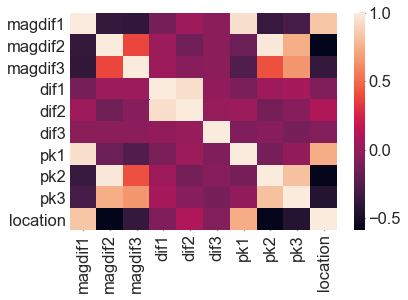

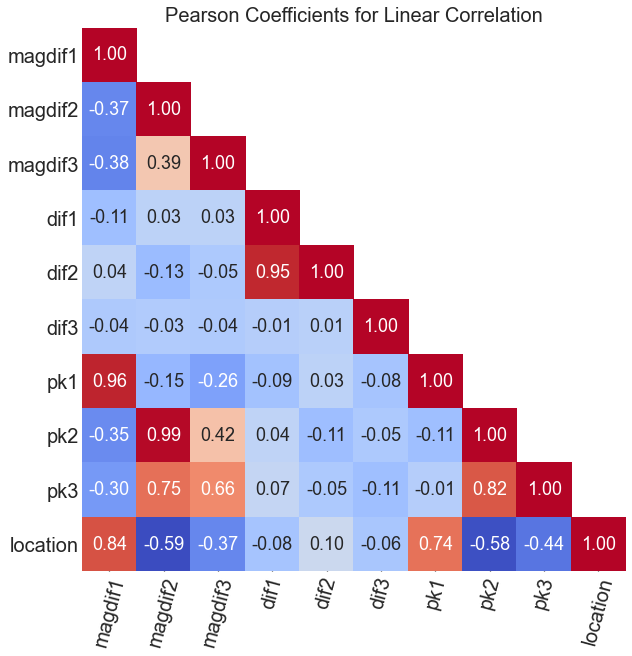

In [204]:
df = pd.read_csv('walkingData10202020.csv')
df_cols = ['magdif1','magdif2','magdif3','dif1','dif2','dif3','pk1','pk2','pk3','location']
df.columns = df_cols
df.corr(method='pearson').round(2)
sns.heatmap(df.corr(method='pearson'))
corr = df.corr(method='pearson')#'spearman'
corr.columns = df_cols
df_len = len(df_cols)
fs = 20


fig, ax=plt.subplots(figsize=(df_len,df_len))
sns.set(font_scale=1.5)
sns.set_style("ticks",{'xtick.direction': 'in', # set the style of the plot using seaborn
                       'ytick.direction':'in',
                       'xtick.top': False,'ytick.right': False})
mask = np.triu(np.ones_like(corr, dtype=np.bool),k=1)
cmap = plt.get_cmap('coolwarm')
sns.heatmap(corr, mask = mask, cbar_kws={"shrink": .2}, annot=True, fmt='.2f', 
            cmap=cmap, cbar=False, ax=ax, square=True)
ax.set_xlim(0, df_len)
ax.set_ylim(df_len, 0)
ax.set_title("Pearson Coefficients for Linear Correlation", fontsize = 20)
plt.xticks(rotation=75, fontsize = fs)
plt.yticks(rotation=0, fontsize = fs) 
plt.show()

In [205]:
# adapted from data_visual_cement_dataset
def plot_predictions(y, y_hat, labels): 
    plt.rcParams.update({'font.size': 20, 'font.sans-serif':'arial'})
    y, y_hat, labels = list(
        map(
            lambda l: l if isinstance(l, list) else [l],
            [y, y_hat, labels]))
    color_list = ['blue', 'red']
    n_plots = len(y)
    y_min = min([min(z) for z in y])
    y_max = max([max(z) for z in y])
    lims = (y_min, y_max)
    fig, ax = plt.subplots(
        1, n_plots, figsize=(7*n_plots, 6),
        squeeze=False, sharex=True, sharey=True)
    for axis, target, prediction, label, color in zip(ax[0, :], y, y_hat, labels, color_list):
        # Scatter plot
        axis.scatter(target, prediction, alpha=0.3, c = color)

        # Title and labels
        rmse_value = np.sqrt(mean_squared_error(target, prediction))
        title = label + " (RMSE=%.3f)" % rmse_value
        axis.set_title(title)
        axis.set_xlabel('Target Location')
        axis.set_ylabel('Predicted Location')
        axis.plot(lims, lims, 'k--', alpha=0.75, zorder=0)
        axis.yaxis.set_tick_params(which='both', labelleft=True)

    plt.subplots_adjust(wspace = 0.3)
    plt.show()

# XGBoost

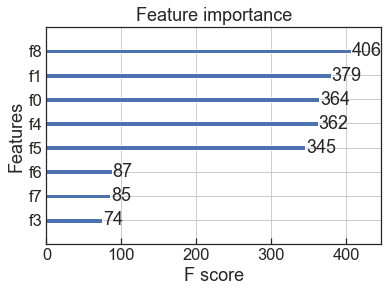

Accuracy: 74.44%
Thresh=0.000, n=9, Accuracy: 74.44%
Thresh=0.029, n=8, Accuracy: 74.44%
Thresh=0.054, n=7, Accuracy: 75.56%
Thresh=0.099, n=6, Accuracy: 74.44%
Thresh=0.134, n=5, Accuracy: 73.33%
Thresh=0.140, n=4, Accuracy: 70.00%
Thresh=0.151, n=3, Accuracy: 70.00%
Thresh=0.176, n=2, Accuracy: 68.89%
Thresh=0.217, n=1, Accuracy: 41.11%


In [206]:
# fit model no training data
model = XGBClassifier()
model.fit(inputsNorm, outputs)
# plot feature importance
plot_importance(model)
pyplot.show()

class MyXGBClassifier(XGBClassifier):
    @property
    def coef_(self):
        return None

X_train, X_test, y_train, y_test = train_test_split(inputsNorm, outputs, test_size=0.3, random_state=7)
model = MyXGBClassifier()
model.fit(X_train, y_train)
# make predictions for test data and evaluate
predictions = model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
# Fit model using each importance as a threshold
thresholds = sort(model.feature_importances_)
for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    # train model
    selection_model = XGBClassifier()
    selection_model.fit(select_X_train, y_train)
    # eval model
    select_X_test = selection.transform(X_test)
    predictions = selection_model.predict(select_X_test)
    accuracy = accuracy_score(y_test, predictions)
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))

## Try different classifiers

In [242]:
def tryClassifier(inp, out, model, param_distributions, n_it, name_str, onehot):
    accuracy_all = np.zeros(n_fold)
    num_acc = [0,0,0,0,0,0]
    div_count = [0,0,0,0,0,0]
    yTrainAll = []
    yHatTrainAll = []
    yTestAll = []
    yHatTestAll = []
    
    for k, (train, test) in enumerate(sk_fold.split(inp, out)):
        xTrain = inp[train]
        yTrain = out[train]
        xTest = inp[test]
        yTest = out[test]

        model_cv = RandomizedSearchCV(model, param_distributions=param_distributions,
        n_iter=n_it, verbose=0)
        model_cv.fit(xTrain, yTrain)
#         print('Best params: \n', model_cv.best_params_)
        
        yHatTest = model_cv.predict(xTest)
        yHatTrain = model_cv.predict(xTrain)

        accuracy = metrics.accuracy_score(yTest, yHatTest)
        accuracy_all[k] = accuracy
        
        if onehot:
            yTrain = enc.inverse_transform(yTrain)
            yTest = enc.inverse_transform(yTest)
            yHatTest = enc.inverse_transform(yHatTest)
            yHatTrain = enc.inverse_transform(yHatTrain)

        # saving values to plot
        yTrainAll = np.append(yTrainAll,yTrain)
        yHatTrainAll = np.append(yHatTrainAll, yHatTrain)
        yTestAll = np.append(yTestAll,yTest)
        yHatTestAll = np.append(yHatTestAll, yHatTest)

        # finding accuracy for each location
        num_acc_temp = []
        for i in range(7):
            if i > 0:
                idx = np.where(yTest == i)
                if len(idx[0])>0:
                    num_acc_temp.append(metrics.accuracy_score(yTest[idx],yHatTest[idx]))
                    div_count[i-1] += 1
                else:
                    num_acc_temp.append(0)
        num_acc = [num_acc[i]+num_acc_temp[i] for i in range(6)]
        print ('classification accuracy : %.2f%%' % (100 * accuracy))

    print('#####')
    print(name_str + ' Cross-validation results:')
    print('Folds: %i, mean acc: %.3f' % (len(accuracy_all), np.mean(np.abs(accuracy_all))))
    # print('#####')
    print('Prediction accuracy for each location:')
    print([num_acc[i]/div_count[i] for i in range(6)])

#     plot_predictions(yTrainAll, yHatTrainAll,'Train')
#     plot_predictions(yTestAll, yHatTestAll,'Test')

    confusion_train = confusion_matrix(yTrainAll, yHatTrainAll)
    confusion_test = confusion_matrix(yTestAll, yHatTestAll)
    
    lbls = ['1','2','3','4','5','6']
    
    df_cm = pd.DataFrame(confusion_train, index=lbls,
                  columns=lbls)
    plt.figure(figsize = (10,7))
    ax1 = plt.axes()
    ax1.set_title("Train Data Confusion Matrix", fontsize = 18)
    sns.heatmap(df_cm, annot=True)


    df_cm = pd.DataFrame(confusion_test, index=lbls,
                  columns=lbls)
    plt.figure(figsize = (10,7))
    ax2 = plt.axes()
    ax2.set_title("Test Data Confusion Matrix", fontsize = 18)
    sns.heatmap(df_cm, annot=True)
    
    from sklearn.metrics import mean_squared_error
    from sklearn.metrics import mean_absolute_error
    rmse_value = np.sqrt(mean_squared_error(yTestAll, yHatTestAll))
    
    print('#####')
    print('RMSE: ')
    print(rmse_value)
    print('#####')
    print('Mean absolute error: ')
    print(mean_absolute_error(yTestAll, yHatTestAll))

In [243]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
rmse_value = np.sqrt(mean_squared_error(yTestAll, yHatTestAll))

print(outputs)
print('#####')
print('RMSE: ')
print(rmse_value)
print('#####')
print('Mean absolute error: ')
print(mean_absolute_error(yTestAll, yHatTestAll))

[1. 2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 6.
 1. 2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 6.
 1. 2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 6.
 1. 2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 6.
 1. 2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 6.
 1. 2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 6.
 1. 2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 6.
 1. 2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 6.
 1. 2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 6.
 1. 2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 6.
 1. 2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 6.
 1. 2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 6.
 1. 2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 6.]
#####
RMSE: 
1.0181682899534177
#####
Mean absolute error: 
0.36333333333333334


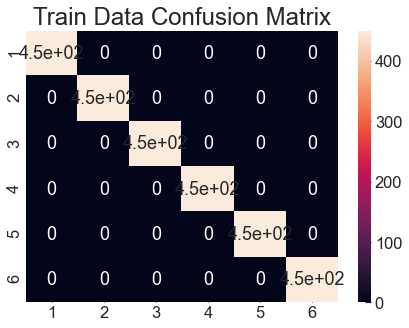

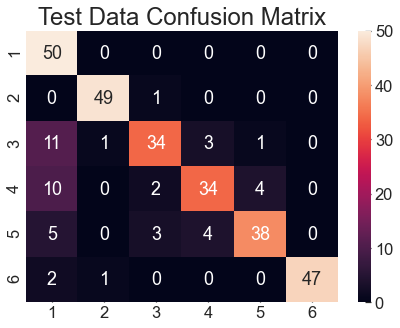

In [247]:
confusion_train = confusion_matrix(yTrainAll, yHatTrainAll)
confusion_test = confusion_matrix(yTestAll, yHatTestAll)

lbls = ['1','2','3','4','5','6']

df_cm = pd.DataFrame(confusion_train, index=lbls,
              columns=lbls)
plt.figure(figsize = (7,5))
ax1 = plt.axes()
ax1.set_title("Train Data Confusion Matrix", fontsize = 24)
sns.heatmap(df_cm, annot=True)


df_cm = pd.DataFrame(confusion_test, index=lbls,
              columns=lbls)
plt.figure(figsize = (7,5))
ax2 = plt.axes()
ax2.set_title("Test Data Confusion Matrix", fontsize = 24)
sns.heatmap(df_cm, annot=True)

classification accuracy : 83.33%
classification accuracy : 80.00%
classification accuracy : 80.00%
classification accuracy : 83.33%
classification accuracy : 86.67%
classification accuracy : 86.67%
classification accuracy : 76.67%
classification accuracy : 80.00%
classification accuracy : 80.00%
classification accuracy : 76.67%
#####
KNN Cross-validation results:
Folds: 10, mean acc: 0.813
Prediction accuracy for each location:
[0.9800000000000001, 0.86, 0.5400000000000001, 0.82, 0.7599999999999999, 0.9200000000000002]
#####
RMSE: 
0.5887840577551898
#####
Mean absolute error: 
0.22666666666666666


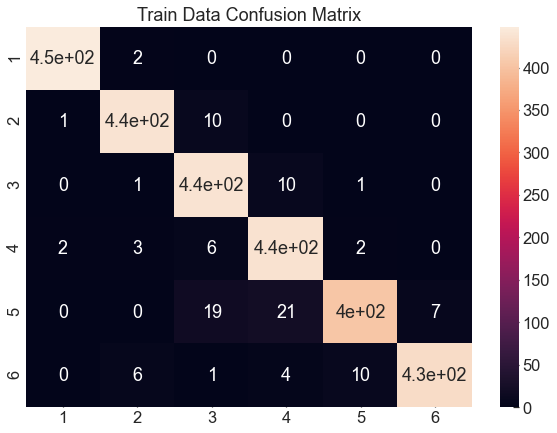

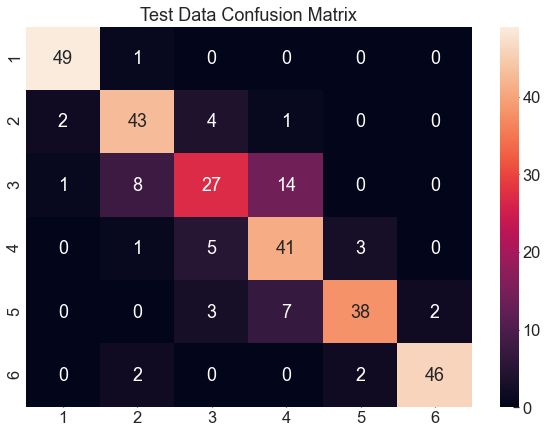

In [276]:
# GBC, 20 iter
model_g = GradientBoostingClassifier(n_estimators=50)
param_distributions_g = {
    'n_estimators': stats.randint(low=10, high=1000),
    'max_depth': stats.randint(low=2, high=6),
    'min_samples_split': stats.randint(low=2, high=5),
    'learning_rate': [1, 0.5, 0.25, 0.1, 0.05, 0.01]
}

# KNN, 100 iter
model_k = KNeighborsClassifier(n_neighbors=4)
param_distributions_k = {
    'n_neighbors': stats.randint(low=3, high=15),
    'weights': ['uniform','distance'],
    'algorithm': ['auto','ball_tree','kd_tree','brute']
}

# RF, 50 iter
model_r = RandomForestClassifier(n_estimators=200)
param_distributions_r = {
    'n_estimators': stats.randint(low=50, high=300),
    'min_samples_split': stats.randint(low=2, high=6),
    'min_samples_leaf': stats.randint(low=1, high=5),
    'min_weight_fraction_leaf': [0.5, 0.25, 0.1, 0.05, 0.01, 0.0]
}

tryClassifier(reducedInputsNorm , outputs_unorder, model_r, param_distributions_r, 50, 'KNN', False)

## KMeans Semisupervised

[1. 2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 6.
 1. 2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 6.
 1. 2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 6.
 1. 2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 6.
 1. 2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 6.
 1. 2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 6.
 1. 2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 6.
 1. 2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 6.
 1. 2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 6.
 1. 2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 6.
 1. 2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 6.
 1. 2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 6.
 1. 2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 6.]
[[2.97371925e-04 5.31662461e-03 0.00000000e+00 4.09337905e-01
  1.00650070e-03]
 [2.52

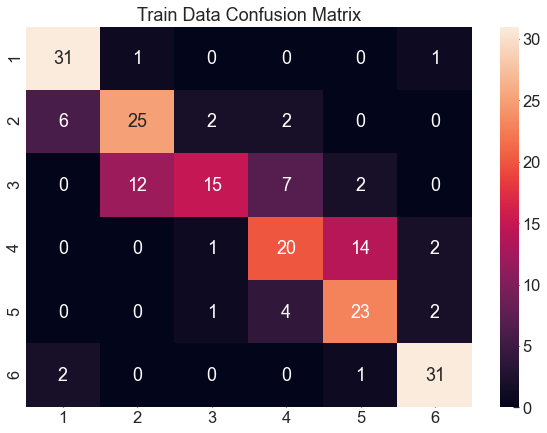

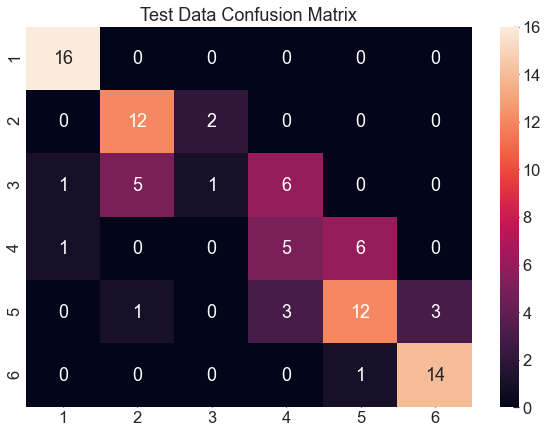

In [209]:
from sklearn.cluster import KMeans
import numpy as np
print(outputs)

init_centroids = reducedInputsNorm[0:6,:]
print(init_centroids)

X_train, X_test, y_train, y_test = train_test_split(reducedInputsNorm[6:,:], outputs[6:], test_size=0.3)
kmeans = KMeans(n_clusters=6, init=init_centroids, n_init=1).fit(X_train)
y_hat_test = kmeans.predict(X_test)
y_hat_train = kmeans.labels_
# plot_predictions(y_train,kmeans.labels_, 'Train')  
# plot_predictions(y_test,y_hat_test, 'Test')

y_test = [x - 1 for x in y_test]
y_train = [x - 1 for x in y_train]

confusion_train = confusion_matrix(y_train, y_hat_train)
confusion_test = confusion_matrix(y_test, y_hat_test)

lbls = ['1','2','3','4','5','6']

df_cm = pd.DataFrame(confusion_train, index=lbls,
                  columns=lbls)
plt.figure(figsize = (10,7))
ax1 = plt.axes()
ax1.set_title("Train Data Confusion Matrix", fontsize = 18)
sns.heatmap(df_cm, annot=True)


df_cm = pd.DataFrame(confusion_test, index=lbls,
              columns=lbls)
plt.figure(figsize = (10,7))
ax2 = plt.axes()
ax2.set_title("Test Data Confusion Matrix", fontsize = 18)
sns.heatmap(df_cm, annot=True)


## Linear Regression

In [251]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor

# regressor = GradientBoostingRegressor()
from sklearn.multioutput import MultiOutputRegressor

params = {'n_estimators': 5000, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 2
         }

regressor = MultiOutputRegressor(GradientBoostingRegressor(**params))

X_train, X_test, y_train, y_test = train_test_split(reducedInputsNorm, coord_outputs, test_size=0.3)

# regressor = LinearRegression()
regressor.fit(X_train, y_train)

y_hat_train = regressor.predict(X_train)  # Training set predictions
y_hat_test = regressor.predict(X_test)  # Test set predictions

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
# def plot_predictions(y, y_hat, labels):
#     plt.rcParams.update({'font.size': 18, 'font.sans-serif':'arial'})
#     y, y_hat, labels = list(
#         map(
#             lambda l: l if isinstance(l, list) else [l],
#             [y, y_hat, labels]))
#     color_list = ['blue', 'red']
#     n_plots = len(y)
#     y_min = min([min(z) for z in y])
#     y_max = max([max(z) for z in y])
#     lims = (y_min, y_max)
#     fig, ax = plt.subplots(
#         1, n_plots, figsize=(6*n_plots, 5),
#         squeeze=False, sharex=True, sharey=True)
#     for axis, target, prediction, label, color in zip(ax[0, :], y, y_hat, labels, color_list):
#         # Scatter plot
#         axis.scatter(target, prediction, alpha=0.3, c = color)

#         # Title and labels
#         rmse_value = np.sqrt(mean_squared_error(target, prediction))
#         title = label + " (RMSE=%.3f)" % rmse_value
#         axis.set_title(title)
#         axis.set_xlabel('Target Location')
#         axis.set_ylabel('Predicted Location')
#         axis.plot(lims, lims, 'k--', alpha=0.75, zorder=0)
#         axis.yaxis.set_tick_params(which='both', labelleft=True)

#     plt.subplots_adjust(wspace = 0.3)
#     plt.show()


y_hat_train = np.round(y_hat_train)
y_hat_test = np.round(y_hat_test)

# plot_predictions([y_train, y_test], [y_hat_train, y_hat_test],    labels=['Train', 'Test'])
uncoord_y_hat_train = uncoordinate(y_hat_train)
uncoord_y_hat_test = uncoordinate(y_hat_test)
uncoord_y_train = uncoordinate(y_train)
uncoord_y_test = uncoordinate(y_test)

confusion_train = confusion_matrix(uncoord_y_train, uncoord_y_hat_train)
confusion_test = confusion_matrix(uncoord_y_test, uncoord_y_hat_test)

# calculate accuracy
comp = abs(uncoord_y_test-uncoord_y_hat_test)
comp[comp > 0] = 1
accuracy = sum(comp)/uncoord_y_test.shape[0]
print('#####')
print('Accuracy: ')
print(float(1-accuracy))
rmse_value = np.sqrt(mean_squared_error(uncoord_y_test, uncoord_y_hat_test))
print('#####')
print('RMSE: ')
print(rmse_value)
print('#####')
print('Mean absolute error: ')
print(mean_absolute_error(uncoord_y_test, uncoord_y_hat_test))


lbls = ['1','2','3','4','5','6']

df_cm = pd.DataFrame(confusion_train, index=lbls,
                  columns=lbls)
plt.figure(figsize = (10,7))
ax1 = plt.axes()
ax1.set_title("Train Data Confusion Matrix", fontsize = 18)
sns.heatmap(df_cm, annot=True)


df_cm = pd.DataFrame(confusion_test, index=lbls,
              columns=lbls)
plt.figure(figsize = (10,7))
ax2 = plt.axes()
ax2.set_title("Test Data Confusion Matrix", fontsize = 18)
sns.heatmap(df_cm, annot=True)


ValueError: y must have at least two dimensions for multi-output regression but has only one.

classification accuracy : 80.00%
classification accuracy : 80.00%
classification accuracy : 86.67%
classification accuracy : 86.67%
classification accuracy : 73.33%
classification accuracy : 83.33%
classification accuracy : 86.67%
classification accuracy : 83.33%
classification accuracy : 86.67%
classification accuracy : 66.67%
#####
Gradient Boosting Regression Cross-validation results:
Folds: 10, mean acc: 0.813
#####
RMSE: 
0.5773502691896257
#####
Mean absolute error: 
0.21666666666666667


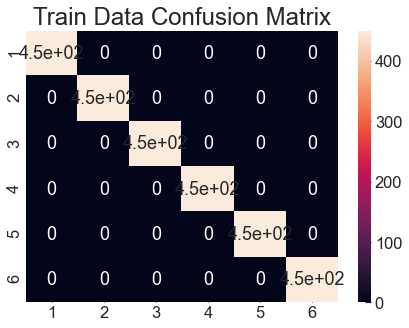

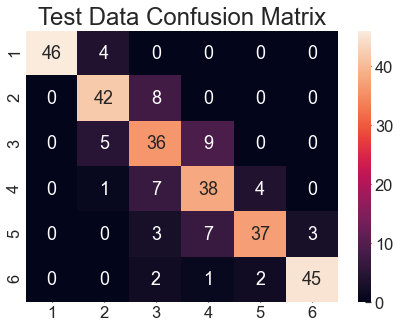

In [277]:
# real one with cross valid
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor

# regressor = GradientBoostingRegressor()
from sklearn.multioutput import MultiOutputRegressor

params = {'n_estimators': 5000, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 2
         }

# regressor = MultiOutputRegressor(GradientBoostingRegressor(**params))

regressor = GradientBoostingRegressor(n_estimators=5000, max_depth=6, min_samples_split=2, min_samples_leaf=2)

accuracy_all = np.zeros(n_fold)
num_acc = [0,0,0,0,0,0,0,0,0,0]
div_count = [0,0,0,0,0,0]
yTrainAll = []
yHatTrainAll = []
yTestAll = []
yHatTestAll = []
    
for k, (train, test) in enumerate(sk_fold.split(reducedInputsNorm, outputs)):
    
    X_train = reducedInputsNorm[train]
    X_test = reducedInputsNorm[test]
    
#     y_train = coord_outputs[train]
#     y_test = coord_outputs[test]
    
#     y_train = outputs_unorder[train]
#     y_test = outputs_unorder[test]
    
    y_train = outputs[train]
    y_test = outputs[test]

    regressor.fit(X_train, y_train)

    y_hat_train = regressor.predict(X_train)  # Training set predictions
    y_hat_test = regressor.predict(X_test)  # Test set predictions

    from sklearn.metrics import mean_squared_error
    from sklearn.metrics import mean_absolute_error
    
    y_hat_train = np.round(y_hat_train)
    y_hat_test = np.round(y_hat_test)

    # plot_predictions([y_train, y_test], [y_hat_train, y_hat_test],    labels=['Train', 'Test'])
#     y_hat_train = uncoordinate(y_hat_train)
#     y_hat_test = uncoordinate(y_hat_test)
#     y_train = uncoordinate(y_train)
#     y_test = uncoordinate(y_test)

#     confusion_train = confusion_matrix(uncoord_y_train, uncoord_y_hat_train)
#     confusion_test = confusion_matrix(uncoord_y_test, uncoord_y_hat_test)


# saving values to plot
    yTrainAll = np.append(yTrainAll,y_train)
    yHatTrainAll = np.append(yHatTrainAll, y_hat_train)
    yTestAll = np.append(yTestAll,y_test)
    yHatTestAll = np.append(yHatTestAll, y_hat_test)

    # finding accuracy for each location
#     num_acc_temp = []
#     for i in range(7):
#         if i > 0:
#             idx = np.where(uncoord_y_test == i)
#             if len(idx[0])>0:
#                 num_acc_temp.append(metrics.accuracy_score(uncoord_y_test[idx],uncoord_y_hat_test[idx]))
#                 div_count[i-1] += 1
#             else:
#                 num_acc_temp.append(0)
#     num_acc = [num_acc[i]+num_acc_temp[i] for i in range(6)]
    comp = abs(y_test-y_hat_test)
    comp[comp > 0] = 1
    accuracy = sum(comp)/y_test.shape[0]
    accuracy_all[k] = 1-accuracy
    print ('classification accuracy : %.2f%%' % (100 * (1-accuracy)))

print('#####')
print('Gradient Boosting Regression' + ' Cross-validation results:')
print('Folds: %i, mean acc: %.3f' % (len(accuracy_all), np.mean(np.abs(accuracy_all))))
# print('#####')
# print('Prediction accuracy for each location:')
# print([num_acc[i]/div_count[i] for i in range(6)])

#     plot_predictions(yTrainAll, yHatTrainAll,'Train')
#     plot_predictions(yTestAll, yHatTestAll,'Test')

confusion_train = confusion_matrix(yTrainAll, yHatTrainAll)
confusion_test = confusion_matrix(yTestAll, yHatTestAll)

lbls = ['1','2','3','4','5','6']

df_cm = pd.DataFrame(confusion_train, index=lbls,
              columns=lbls)
plt.figure(figsize = (7,5))
ax1 = plt.axes()
ax1.set_title("Train Data Confusion Matrix", fontsize = 24)
sns.heatmap(df_cm, annot=True)


df_cm = pd.DataFrame(confusion_test, index=lbls,
              columns=lbls)
plt.figure(figsize = (7,5))
ax2 = plt.axes()
ax2.set_title("Test Data Confusion Matrix", fontsize = 24)
sns.heatmap(df_cm, annot=True)

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
rmse_value = np.sqrt(mean_squared_error(yTestAll, yHatTestAll))
    
print('#####')
print('RMSE: ')
rmse_value = np.sqrt(mean_squared_error(uncoord_y_test, uncoord_y_hat_test))
print(rmse_value)
print('#####')
print('Mean absolute error: ')
print(mean_absolute_error(yTestAll, yHatTestAll))

#     # calculate accuracy
#     comp = abs(uncoord_y_test-uncoord_y_hat_test)
#     comp[comp > 0] = 1
#     accuracy = sum(comp)/uncoord_y_test.shape[0]
#     print('#####')
#     print('Accuracy: ')
#     print(float(1-accuracy))
#     rmse_value = np.sqrt(mean_squared_error(uncoord_y_test, uncoord_y_hat_test))
#     print('#####')
#     print('RMSE: ')
#     print(rmse_value)
#     print('#####')
#     print('Mean absolute error: ')
#     print(mean_absolute_error(uncoord_y_test, uncoord_y_hat_test))

# confusion_train = confusion_matrix(uncoord_y_train, uncoord_y_hat_train)
# confusion_test = confusion_matrix(uncoord_y_test, uncoord_y_hat_test)

# lbls = ['1','2','3','4','5','6']

# df_cm = pd.DataFrame(confusion_train, index=lbls,
#                   columns=lbls)
# plt.figure(figsize = (10,7))
# ax1 = plt.axes()
# ax1.set_title("Train Data Confusion Matrix", fontsize = 18)
# sns.heatmap(df_cm, annot=True)


# df_cm = pd.DataFrame(confusion_test, index=lbls,
#               columns=lbls)
# plt.figure(figsize = (10,7))
# ax2 = plt.axes()
# ax2.set_title("Test Data Confusion Matrix", fontsize = 18)
# sns.heatmap(df_cm, annot=True)


In [253]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor

# regressor = GradientBoostingRegressor()
from sklearn.multioutput import MultiOutputRegressor

params = {'n_estimators': 5000, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 2
         }

regressor = MultiOutputRegressor(GradientBoostingRegressor(**params))

accuracy_all = np.zeros(n_fold)
num_acc = [0,0,0,0,0,0]
div_count = [0,0,0,0,0,0]
yTrainAll = []
yHatTrainAll = []
yTestAll = []
yHatTestAll = []
    
for k, (train, test) in enumerate(sk_fold.split(reducedInputsNorm, outputs)):
    regressor.fit(X_train, y_train)

    y_hat_train = regressor.predict(X_train)  # Training set predictions
    y_hat_test = regressor.predict(X_test)  # Test set predictions

    from sklearn.metrics import mean_squared_error
    from sklearn.metrics import mean_absolute_error
    
    y_hat_train = np.round(y_hat_train)
    y_hat_test = np.round(y_hat_test)

    # plot_predictions([y_train, y_test], [y_hat_train, y_hat_test],    labels=['Train', 'Test'])
    uncoord_y_hat_train = uncoordinate(y_hat_train)
    uncoord_y_hat_test = uncoordinate(y_hat_test)
    uncoord_y_train = uncoordinate(y_train)
    uncoord_y_test = uncoordinate(y_test)

    confusion_train = confusion_matrix(uncoord_y_train, uncoord_y_hat_train)
    confusion_test = confusion_matrix(uncoord_y_test, uncoord_y_hat_test)

    # calculate accuracy
    comp = abs(uncoord_y_test-uncoord_y_hat_test)
    comp[comp > 0] = 1
    accuracy = sum(comp)/uncoord_y_test.shape[0]
    print('#####')
    print('Accuracy: ')
    print(float(1-accuracy))
    rmse_value = np.sqrt(mean_squared_error(uncoord_y_test, uncoord_y_hat_test))
    print('#####')
    print('RMSE: ')
    print(rmse_value)
    print('#####')
    print('Mean absolute error: ')
    print(mean_absolute_error(uncoord_y_test, uncoord_y_hat_test))

confusion_train = confusion_matrix(uncoord_y_train, uncoord_y_hat_train)
confusion_test = confusion_matrix(uncoord_y_test, uncoord_y_hat_test)

lbls = ['1','2','3','4','5','6']

df_cm = pd.DataFrame(confusion_train, index=lbls,
                  columns=lbls)
plt.figure(figsize = (10,7))
ax1 = plt.axes()
ax1.set_title("Train Data Confusion Matrix", fontsize = 18)
sns.heatmap(df_cm, annot=True)


df_cm = pd.DataFrame(confusion_test, index=lbls,
              columns=lbls)
plt.figure(figsize = (10,7))
ax2 = plt.axes()
ax2.set_title("Test Data Confusion Matrix", fontsize = 18)
sns.heatmap(df_cm, annot=True)


ValueError: Supported target types are: ('binary', 'multiclass'). Got 'multiclass-multioutput' instead.

In [232]:
from scipy import stats 
from sklearn.model_selection import RandomizedSearchCV

param_distributions = {
    'n_estimators': stats.randint(low=10, high=1000),
    'max_depth': stats.randint(low=2, high=6),
    'min_samples_split': stats.randint(low=2, high=5),
    'learning_rate': [1, 0.5, 0.25, 0.1, 0.05, 0.01]
}


regressor_cv = RandomizedSearchCV(
    regressor, param_distributions=param_distributions,
    n_iter=100, verbose=1)
regressor_cv.fit(X_train, y_train)

print('Best params: \n', regressor_cv.best_params_)

y_hat_train = regressor_cv.predict(X_train)
y_hat_test = regressor_cv.predict(X_test)

y_hat_train = np.round(y_hat_train)
y_hat_test = np.round(y_hat_test)

# plot_predictions([y_train, y_test], [y_hat_train, y_hat_test],    labels=['Train', 'Test'])

uncoord_y_hat_train = uncoordinate(y_hat_train)
uncoord_y_hat_test = uncoordinate(y_hat_test)
uncoord_y_train = uncoordinate(y_train)
uncoord_y_test = uncoordinate(y_test)

confusion_train = confusion_matrix(uncoord_y_train, uncoord_y_hat_train)
confusion_test = confusion_matrix(uncoord_y_test, uncoord_y_hat_test)


# confusion_train = confusion_matrix(y_train, y_hat_train)
# confusion_test = confusion_matrix(y_test, y_hat_test)

lbls = ['1','2','3','4','5','6']

df_cm = pd.DataFrame(confusion_train, index=lbls,
                  columns=lbls)
plt.figure(figsize = (10,7))
ax1 = plt.axes()
ax1.set_title("Train Data Confusion Matrix", fontsize = 18)
sns.heatmap(df_cm, annot=True)


df_cm = pd.DataFrame(confusion_test, index=lbls,
              columns=lbls)
plt.figure(figsize = (10,7))
ax2 = plt.axes()
ax2.set_title("Test Data Confusion Matrix", fontsize = 18)
sns.heatmap(df_cm, annot=True)


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


ValueError: Invalid parameter learning_rate for estimator MultiOutputRegressor(estimator=GradientBoostingRegressor(max_depth=4,
                                                         min_samples_leaf=2,
                                                         n_estimators=5000)). Check the list of available parameters with `estimator.get_params().keys()`.

## Neural Network Regression

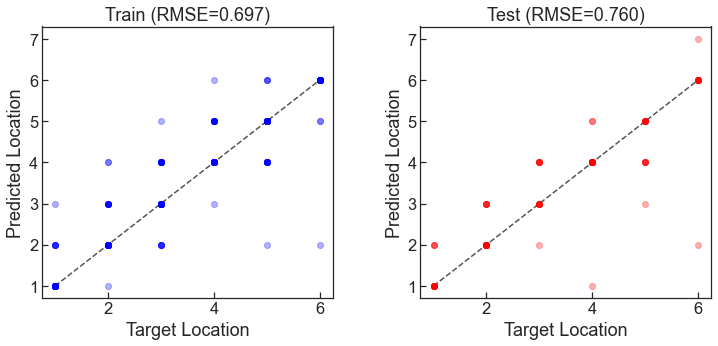

ValueError: Shape of passed values is (7, 7), indices imply (6, 6)

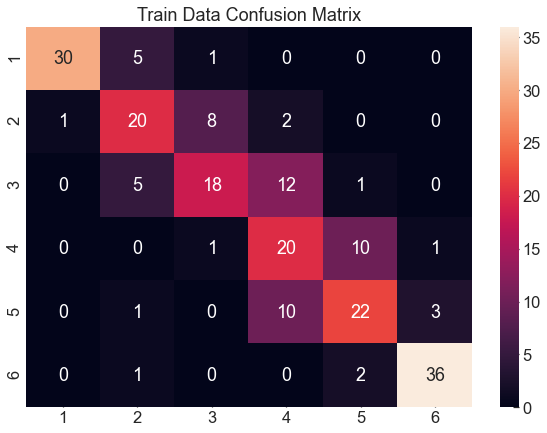

In [211]:
from sklearn.neural_network import MLPRegressor
regressor = MLPRegressor(
    hidden_layer_sizes=[256, 128, 64], max_iter=1000)
regressor.fit(X_train, y_train)
y_hat_train = regressor.predict(X_train)
y_hat_test = regressor.predict(X_test)

# Plot predictions
y_hat_train = np.round(y_hat_train)
y_hat_test = np.round(y_hat_test)

plot_predictions([y_train, y_test], [y_hat_train, y_hat_test],    labels=['Train', 'Test'])

confusion_train = confusion_matrix(y_train, y_hat_train)
confusion_test = confusion_matrix(y_test, y_hat_test)

lbls = ['1','2','3','4','5','6']

df_cm = pd.DataFrame(confusion_train, index=lbls,
                  columns=lbls)
plt.figure(figsize = (10,7))
ax1 = plt.axes()
ax1.set_title("Train Data Confusion Matrix", fontsize = 18)
sns.heatmap(df_cm, annot=True)


df_cm = pd.DataFrame(confusion_test, index=lbls,
              columns=lbls)
plt.figure(figsize = (10,7))
ax2 = plt.axes()
ax2.set_title("Test Data Confusion Matrix", fontsize = 18)
sns.heatmap(df_cm, annot=True)




## Trash

In [134]:
# n_col = 3 # num of columns per row in the figure
# y_indx = -1 
# color_indx = -2 
# fs = 20

# cmap = plt.get_cmap('coolwarm', 10)

# for n in np.arange(0, ncols, n_col):
#         fig,axes = plt.subplots(1, n_col, figsize=(18, 3.5), sharey = False)
#         for i in np.arange(n_col):
#             if n < len(data_labels)-1:
#                 im = axes[i].scatter(inputsNorm[:,n],outputs, s = 20, cmap=cmap, alpha =0.5, edgecolors = 'face')
#                 axes[i].set_xlabel(data_labels[n], fontsize = fs)
#             else:
#                 axes[i].axis("off")
#             n = n+1      
# #         axes[0].set_ylabel(data_labels[y_indx], fontsize = fs)
#         for i in range(len(axes)):
#             axes[i].tick_params(direction='in', length=5, width=1, labelsize = fs*.8, grid_alpha = 0.5)
#             axes[i].grid(True, linestyle='-.')
#         plt.show()

In [4]:
# adapted from week2 XRD_dimensionlity_demo
# Data normalization from 0 to 1 for double column dataframe
# def normdata(data):
#     (len1,w1) = np.shape(data)
#     ndata = np.zeros([len1,w1//2])
#     for i in range(w1//2):
#         ndata[:,i]=(data[:,2*i+1]-min(data[:,2*i+1]))/(max(data[:,2*i+1])-min(data[:,2*i+1]))
#     return ndata
# #data normalization from 0 to 1 for single column dataframe
# def normdatasingle(data):
#     (len1,w1) = np.shape(data)
#     ndata = np.zeros([len1,w1])
#     for i in range(w1):
#         if (max(data[:,i])-min(data[:,i])) != 0:
#             ndata[:,i]=(data[:,i]-min(data[:,i]))/(max(data[:,i])-min(data[:,i]))
#     return ndata

In [11]:
# # adapted from week 1 classification_demo
# # Multinomial Naive Bayes Classifier
# def naive_bayes_classifier(train_x, train_y):
#     from sklearn.naive_bayes import MultinomialNB
#     model = MultinomialNB(alpha=0.01)
#     model.fit(train_x, train_y)
#     return model


# # KNN Classifier
# def knn_classifier(train_x, train_y):
#     from sklearn.neighbors import KNeighborsClassifier
#     model = KNeighborsClassifier(n_neighbors=4)
#     model.fit(train_x, train_y)
#     return model



# # Random Forest Classifier
# def random_forest_classifier(train_x, train_y):
#     from sklearn.ensemble import RandomForestClassifier
#     model = RandomForestClassifier(n_estimators=200)
#     model.fit(train_x, train_y)
#     return model


# # Decision Tree Classifier
# def decision_tree_classifier(train_x, train_y):
#     from sklearn import tree
#     model = tree.DecisionTreeClassifier()
#     model.fit(train_x, train_y)
#     return model


# # GBDT(Gradient Boosting Decision Tree) Classifier
# def gradient_boosting_classifier(train_x, train_y):
#     from sklearn.ensemble import GradientBoostingClassifier
#     model = GradientBoostingClassifier(n_estimators=50)
#     model.fit(train_x, train_y)
#     return model


# # SVM Classifier
# def svm_classifier(train_x, train_y):
#     from sklearn.svm import SVC
#     model = SVC(kernel='rbf', probability=True)
#     model.fit(train_x, train_y)
#     return model



#  # 3 layer neural network classficiation
# def mlp_classifier(train_x,train_y):
#     from sklearn.neural_network import MLPClassifier
#     model =  MLPClassifier(hidden_layer_sizes=(256,128,32), max_iter=20, alpha=1e-4,
#                     solver='ada,', verbose=10, tol=1e-6, random_state=1,
#                     learning_rate_init=.1)
#     model.fit(train_x,train_y)
#     return model